# Demo the Arbitrageur Agent Logic

This notebook:

1. Fetches the latest crvusd contract data into Python objects using `crvusdsim`.
2. Fetches prices and `ExternalMarket`s from the `baseline` scenario.
3. Instantiates an Arbitrageur agent.
4. Checks if there are profitable arbitrages and performs them.

In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from crvusdsim.pool import get
from src.agents.arbitrageur import Arbitrageur
from src.sim.scenario import Scenario
from src.types import PoolGraph


%load_ext autoreload
%autoreload 2

In [2]:
arbitrageur = Arbitrageur()

ETH_POOL = "weth"
(
    pool,
    controller,
    collateral_token,
    stablecoin,
    aggregator,
    stableswap_pools,
    peg_keepers,
    policy,
    factory,
) = get(ETH_POOL, bands_data="controller")

In [3]:
# Verify snapshot context works on StableSwap pools from crvusdsim
i, j = 1, 0

stableswap_pool = stableswap_pools[2]
high = stableswap_pool.get_max_trade_size(i, j)
prev_bals = stableswap_pool.balances.copy()

print("Pre Trade")
print("Balances", prev_bals)
print("High", high)
print("Allowance", stableswap_pool.coins[0].balanceOf[stableswap_pool.address])
print()

with stableswap_pool.use_snapshot_context():
    amt_out = stableswap_pool.trade(i, j, high)
    swap_bals = stableswap_pool.balances.copy()
    print("Post Trade")
    print("Amount out", amt_out)
    print("Balances", swap_bals)
    print("Allowance", stableswap_pool.coins[0].balanceOf[stableswap_pool.address])
    print()

new_bals = stableswap_pool.balances.copy()
print("After reversing snapshot context")
print("Balances", new_bals)
print("Allowance", stableswap_pool.coins[0].balanceOf[stableswap_pool.address])

assert prev_bals == new_bals, (prev_bals, new_bals)
assert swap_bals != new_bals

Pre Trade
Balances [10114723654034, 25767074910220216366569187]
High 12918808792401666455492325
Allowance 10114723654034

Post Trade
Amount out 10012575059851
Balances [101647915363, 38685883702621882822061512]
Allowance 102148594183

After reversing snapshot context
Balances [10114723654034, 25767074910220216366569187]
Allowance 10114723654034


In [4]:
config = "../src/configs/scenarios/baseline.json"
scenario = Scenario(config)
markets = scenario.generate_markets()
prices = scenario.generate_pricepaths(
    "../src/configs/prices/1h_1694894242_1700078242.json"
)

# Set External Market Prices
sample = prices[-1].prices
for in_token in markets:
    for out_token in markets[in_token]:
        markets[in_token][out_token].update_price(sample[in_token][out_token])

[INFO][16:19:35][root]-528814: Reading price config from ../src/configs/scenarios/baseline.json.
[INFO][16:19:35][root]-528814: Fetching 1inch quotes.
[INFO][16:19:42][root]-528814: We have 433440 quotes.
[INFO][16:19:42][root]-528814: Fitting external markets against 1inch quotes.
[INFO][16:19:42][root]-528814: Reading price config from ../src/configs/prices/1h_1694894242_1700078242.json.


In [5]:
# Create a list of all stableswap pools, LLAMMAs, and External Markets.
markets_lst = [item for subdict in markets.values() for item in subdict.values()]
pools = stableswap_pools + [pool] + markets_lst
print(
    f"There are {len(pools)} total pools:\nStableSwap: {len(stableswap_pools)}\nLLAMMA: 1\nExternal Markets: {len(markets_lst)}"
)

There are 35 total pools:
StableSwap: 4
LLAMMA: 1
External Markets: 30


In [6]:
n = 3
graph = PoolGraph(pools)
cycles = graph.find_cycles(n=n)
cycles

[INFO][16:19:43][root]-528814: Found 40 valid cycles of length 3.


[Cycle(Trades: [Swap(pool=<SimCurveStableSwapPool address=0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0 chain=mainnet>, i=0, j=1, amt=None), Swap(pool=<SimCurveStableSwapPool address=0xca978a0528116dda3cba9acd3e68bc6191ca53d0 chain=mainnet>, i=1, j=0, amt=None), Swap(pool=External Market: USDP -> TUSD, i=0, j=1, amt=None)], Expected Profit: None),
 Cycle(Trades: [Swap(pool=<SimCurveStableSwapPool address=0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0 chain=mainnet>, i=0, j=1, amt=None), Swap(pool=<SimCurveStableSwapPool address=0xca978a0528116dda3cba9acd3e68bc6191ca53d0 chain=mainnet>, i=1, j=0, amt=None), Swap(pool=External Market: TUSD -> USDP, i=1, j=0, amt=None)], Expected Profit: None),
 Cycle(Trades: [Swap(pool=<SimCurveStableSwapPool address=0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0 chain=mainnet>, i=0, j=1, amt=None), Swap(pool=<SimCurveStableSwapPool address=0x4dece678ceceb27446b35c672dc7d61f30bad69e chain=mainnet>, i=1, j=0, amt=None), Swap(pool=External Market: USDC -> TUSD, i=0, 

In [8]:
cycle.__dict__

{'trades': [Swap(pool=<SimCurveStableSwapPool address=0x4dece678ceceb27446b35c672dc7d61f30bad69e chain=mainnet>, i=0, j=1, amt=181766383056),
  Swap(pool=<SimCurveStableSwapPool address=0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0 chain=mainnet>, i=1, j=0, amt=182220043483495943315916),
  Swap(pool=External Market: TUSD -> USDC, i=0, j=1, amt=182014592525893454421520)],
 'n': 3,
 'expected_profit': array([5.11817522])}

Best amount linspace: 80127230545
Best profit linspace: 16.933368838272095
Best amount optimize: 181766383056
Best profit optimize: 5.118175221832275


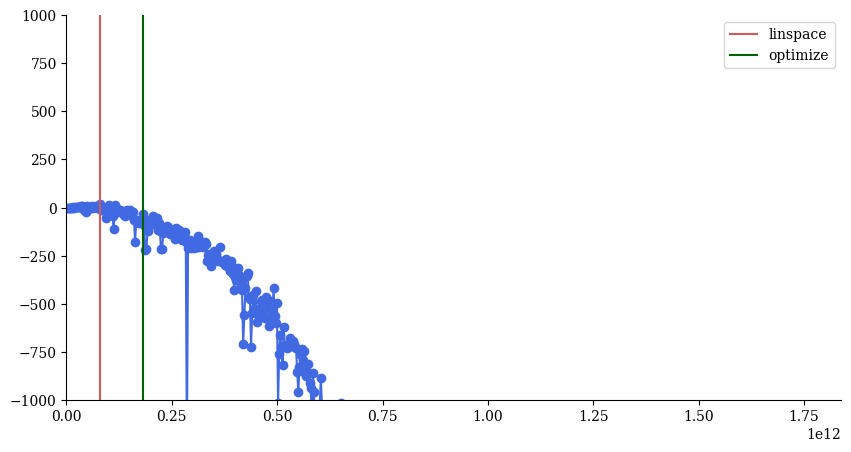

In [9]:
# TODO this curve is probably not smooth because:
# 1. The decimals are not being treated correctly between trades
# 2. The state of each pool is not being snapshot correctly (i.e. it's changing)

# Using i=17 as an example, the optimization does not converge
# to the global max due to the noise in the profit curve.
i = 17
cycle = cycles[i]

trade = cycle.trades[0]
high = trade.pool.get_max_trade_size(trade.i, trade.j) / 10
amts = np.linspace(1, high, 1000)
amts = [int(amt) for amt in amts]
profits = [cycle.populate(amt) for amt in amts]

best_amt_linspace = amts[np.argmax(profits)]
best_profit_linspace = max(profits)

# compare
cycle.optimize()
best_amt_optimize = cycle.trades[0].amt
best_profit_optimize = cycle.expected_profit

f, ax = plt.subplots(figsize=(10, 5))
ax.scatter(amts, profits, color="royalblue")
ax.plot(amts, profits, color="royalblue")
ax.axvline(best_amt_linspace, color="indianred", label="linspace")
ax.axvline(best_amt_optimize, color="darkgreen", label="optimize")

ax.set_xlim(0, 919573381759 * 2)
ax.set_ylim(-1000, 1000)

ax.legend()

print(f"Best amount linspace: {best_amt_linspace}")
print(f"Best profit linspace: {best_profit_linspace}")
print(f"Best amount optimize: {best_amt_optimize}")
print(f"Best profit optimize: {best_profit_optimize}")

In [82]:
# TODO handle failures:
# 1. `trade` method has diff outputs for diff pool types
# 2. LLAMMA snapshot context doesn't snapshot ERC20 balances
# 3. LLAMMA has no attribute `get_max_trade_size`

df = pd.DataFrame(
    columns=["amt_optimize", "amt_linspace", "profit_optimize", "profit_linspace"]
)

for i, cycle in enumerate(cycles):
    try:
        # This is orders of magnitude slower than `optimize`
        trade = cycle.trades[0]
        high = trade.pool.get_max_trade_size(trade.i, trade.j)
        amts = np.linspace(1, high, 1000)
        amts = [int(amt) for amt in amts]
        profits = [cycle.populate(amt) for amt in amts]

        best_amt_linspace = int(amts[np.argmax(profits)])
        best_profit_linspace = int(max(profits))

        cycle.optimize()

        df.loc[i] = [
            cycle.trades[0].amt,
            best_amt_linspace,
            cycle.expected_profit,
            best_profit_linspace,
        ]

    except Exception as e:
        logging.error(f"Cycle {i} failed to optimize: {e}")

df["profit_linspace"] = df["profit_linspace"].astype(float)
df["profit_optimize"] = df["profit_optimize"].astype(float)
df = df.round(3)
df

[ERROR][00:57:28][root]-492739: Cycle 6 failed to optimize: unsupported operand type(s) for /=: 'tuple' and 'int'
[ERROR][00:57:28][root]-492739: Cycle 7 failed to optimize: unsupported operand type(s) for /=: 'tuple' and 'int'
[ERROR][00:57:33][root]-492739: Cycle 14 failed to optimize: unsupported operand type(s) for /=: 'tuple' and 'int'
[ERROR][00:57:33][root]-492739: Cycle 15 failed to optimize: unsupported operand type(s) for /=: 'tuple' and 'int'
[ERROR][00:57:39][root]-492739: Cycle 22 failed to optimize: unsupported operand type(s) for /=: 'tuple' and 'int'
[ERROR][00:57:39][root]-492739: Cycle 23 failed to optimize: unsupported operand type(s) for /=: 'tuple' and 'int'
[ERROR][00:57:44][root]-492739: Cycle 30 failed to optimize: unsupported operand type(s) for /=: 'tuple' and 'int'
[ERROR][00:57:44][root]-492739: Cycle 31 failed to optimize: unsupported operand type(s) for /=: 'tuple' and 'int'
[ERROR][00:57:44][root]-492739: Cycle 32 failed to optimize: 'SimLLAMMAPool' objec

,amt_optimize,amt_linspace,profit_optimize,profit_linspace
0,0,1,0.000,0.0
1,19897912969508400660480,1,-32.266,0.0
2,95064883984029821435904,1,-298.518,0.0
3,768572943356782,1,-0.000,0.0
4,150344932342639,1,-0.000,0.0
5,170405152331282247581696,1,-92.861,0.0
8,74626215133983987990528,69630515065368386469888,43.175,39.0
9,97985999374791999488000,125998074880190425595904,118.473,102.0
10,125053711731312,1,-0.000,0.0
11,151543857532952727519232,1,-46.041,0.0
